In [42]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from simpletransformers.classification import ClassificationModel
import torch

## Explore the dataset

In [3]:
news_df = pd.read_csv("C:/Users/ethan/Documents/fin news NLP/Resources/all-data.csv", encoding="ISO-8859-1", names=['sentiment', 'headline'] )


In [4]:
news_df

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [5]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [6]:
news_df.describe()

,sentiment,headline
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


In [7]:
news_df.drop_duplicates(subset=['headline'],keep='first',inplace=True)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4838 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4838 non-null   object
 1   headline   4838 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


## Visualize the dataset

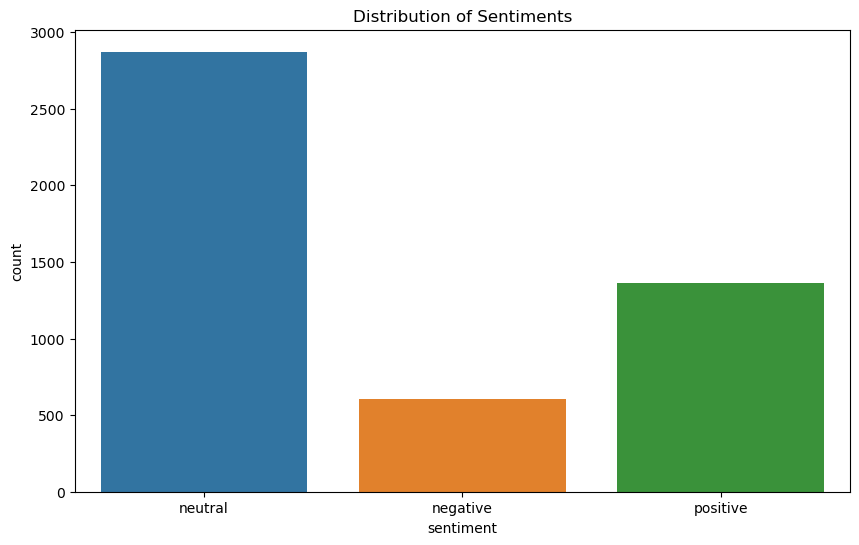

In [8]:
# Plotting sentiment distribution
plt.figure(figsize=(10,6))
sns.countplot(data=news_df, x='sentiment')
plt.title('Distribution of Sentiments')
plt.show()

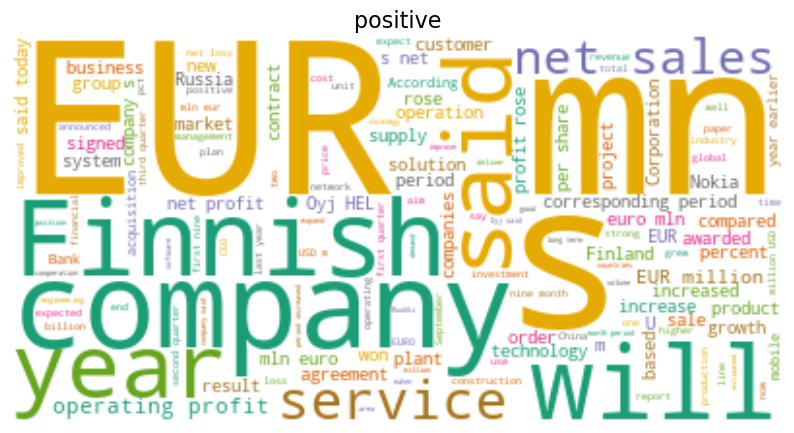

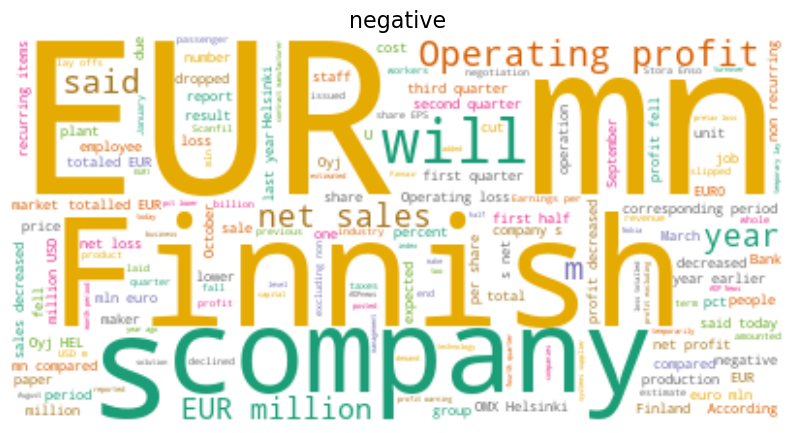

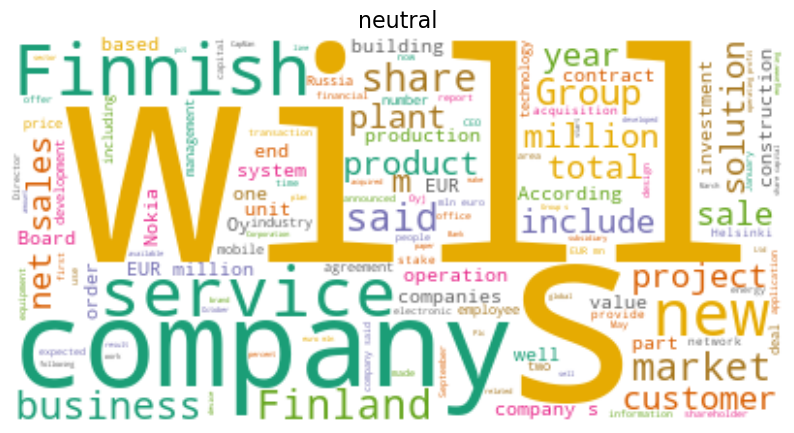

In [9]:

def generate_wordcloud(text, title):
    wc = WordCloud(stopwords=STOPWORDS, background_color="white", colormap="Dark2",
                   max_font_size=150, random_state=42, max_words=150)
    plt.figure(figsize=(10, 8))
    plt.imshow(wc.generate(text), interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# For each sentiment, generate a word cloud
for sentiment in ['positive', 'negative', 'neutral']:
    headlines = " ".join(news_df[news_df['sentiment'] == sentiment]['headline'].tolist())
    generate_wordcloud(headlines, sentiment)


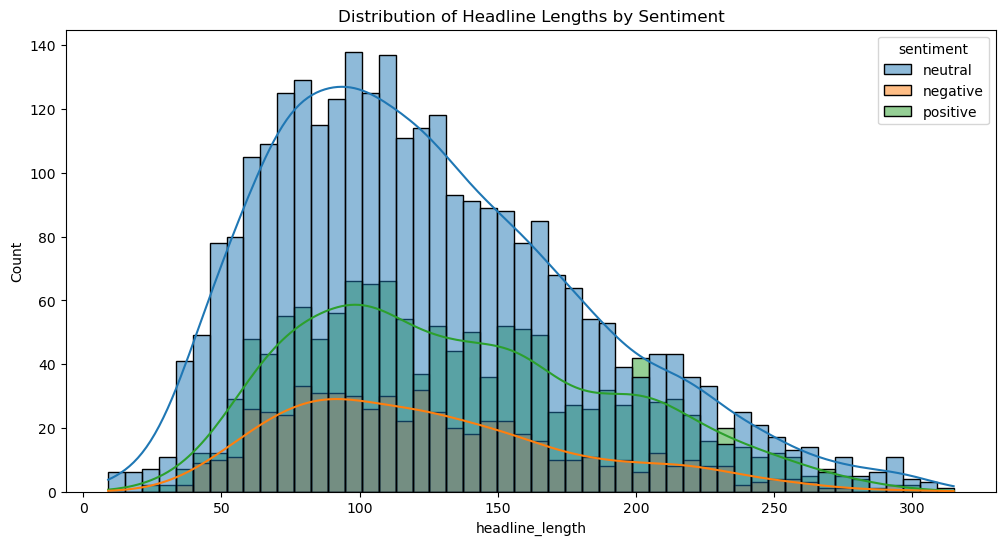

In [10]:
# Adding a column for headline length
news_df['headline_length'] = news_df['headline'].apply(len)

plt.figure(figsize=(12,6))
sns.histplot(data=news_df, x='headline_length', hue='sentiment', bins=50, kde=True)
plt.title('Distribution of Headline Lengths by Sentiment')
plt.show()


## Split the Data for training

In [12]:

news_df['label'] = news_df['sentiment'].map({'positive': 0, 'negative': 1, 'neutral': 2})
train_df, eval_df = train_test_split(news_df, test_size=0.2, random_state=42)

train_df.shape

(3870, 4)

## Remove newline characters

In [13]:
train_df['headline'] = train_df['headline'].replace(r'\n', ' ', regex=True)
eval_df['headline'] = eval_df['headline'].replace(r'\n', ' ', regex=True)


## Select the Model

In [14]:

# Define the model
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Training

In [15]:
# Train the model
model.train_model(train_df[['headline', 'label']])


C:\Users\ethan\anaconda3\envs\dev\lib\site-packages\simpletransformers\classification\classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3870 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/484 [00:00<?, ?it/s]

(484, 0.5135951438218294)

## Model Evaluation

In [16]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df[['headline', 'label']])
print(result)

C:\Users\ethan\anaconda3\envs\dev\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/968 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

{'mcc': 0.719677322917629, 'eval_loss': 0.4454320460742663}


In [29]:
# Get predictions
predictions, raw_outputs = model.predict(eval_df['headline'].tolist())

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [30]:
# Confusion Matrix
cm = confusion_matrix(eval_df['label'], predictions)

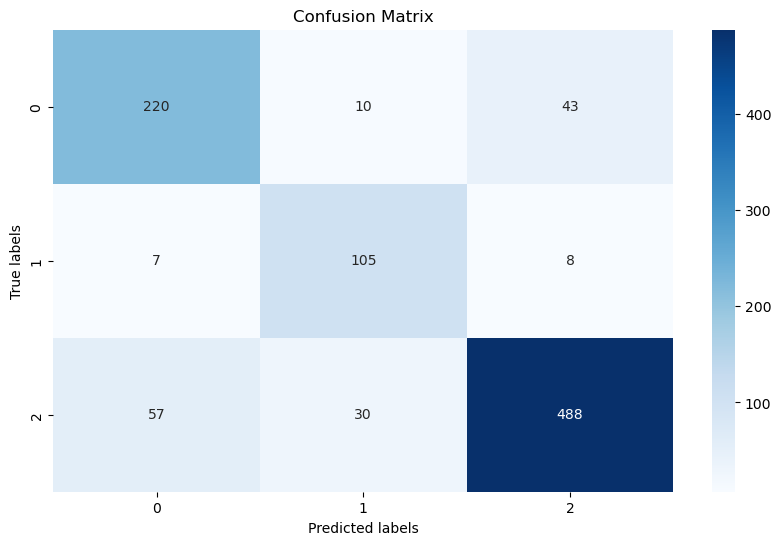

In [31]:
# Visualization of Confusion Matrix
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [52]:
report = classification_report(eval_df['label'], predictions, target_names=['positive', 'negative', 'neutral'])
print(report)

              precision    recall  f1-score   support

    positive       0.77      0.81      0.79       273
    negative       0.72      0.88      0.79       120
     neutral       0.91      0.85      0.88       575

    accuracy                           0.84       968
   macro avg       0.80      0.84      0.82       968
weighted avg       0.85      0.84      0.84       968



In [51]:
# Accuracy
accuracy = accuracy_score(eval_df['label'], predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.99%


In [50]:

save_directory = "C:/Users/ethan/Documents/fin news NLP/Resources"
model.save_model(save_directory)


In [53]:
print(type(model))


<class 'simpletransformers.classification.classification_model.ClassificationModel'>


In [55]:
save_directory = "C:/Users/ethan/Documents/fin news NLP/Resources"
model.save_model(save_directory)



In [56]:
# Save the model weights
model.model.save_pretrained("C:/Users/ethan/Documents/fin news NLP/Resources")

# Save the tokenizer
model.tokenizer.save_pretrained("C:/Users/ethan/Documents/fin news NLP/Resources")


('C:/Users/ethan/Documents/fin news NLP/Resources\\tokenizer_config.json',
 'C:/Users/ethan/Documents/fin news NLP/Resources\\special_tokens_map.json',
 'C:/Users/ethan/Documents/fin news NLP/Resources\\vocab.txt',
 'C:/Users/ethan/Documents/fin news NLP/Resources\\added_tokens.json',
 'C:/Users/ethan/Documents/fin news NLP/Resources\\tokenizer.json')